In [75]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.colors as mcolors  # 使用Normalize需要从matplotlib.colors导入
import matplotlib.cm as cm  # 使用旧方式获取cmap
from matplotlib.patches import Rectangle

In [100]:
# Define the scale bar function
def add_scale_bar(ax, scale_bar_start=0.05, scale_bar_length=0.2, scale_bar_y=0.02, 
                  scale_bar_thickness=600, scale_unit="km", labels_interval=5, zorder=10):

    """
    Add a custom scale bar to a matplotlib axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axis to which the scale bar will be added.
        scale_bar_start (float): Starting position of the scale bar on the x-axis (fraction of total width).
        scale_bar_length (float): Total length of the scale bar (fraction of total width).
        scale_bar_y (float): Position of the scale bar on the y-axis (fraction of total height).
        scale_bar_thickness (int): Thickness of the scale bar in data coordinates (e.g., meters).
        scale_unit (str): Unit of the scale (e.g., 'km').
        labels_interval (int): Interval for scale labels in the given unit.
        zorder (int): Drawing order of the scale bar.
    """
    
    x_start, x_end = ax.get_xlim()
    y_start, y_end = ax.get_ylim()

    bar_x_start = x_start + scale_bar_start * (x_end - x_start)
    bar_x_end = bar_x_start + scale_bar_length * (x_end - x_start)
    bar_y = y_start + scale_bar_y * (y_end - y_start)

    num_sections = int(1 / (scale_bar_length / labels_interval))  # Number of alternating sections
    bar_width = (bar_x_end - bar_x_start) / num_sections
    colors = ['black', 'white'] * (num_sections // 2 + 1)

    for i in range(num_sections):
        rect = Rectangle(
            (bar_x_start + i * bar_width, bar_y),
            bar_width,
            scale_bar_thickness,
            color=colors[i],
            transform=ax.transData,
            clip_on=False,
            zorder=zorder
        )
        ax.add_patch(rect)
        
    for i in range(num_sections + 1):
        ax.text(
            bar_x_start + i * bar_width,
            bar_y + scale_bar_thickness * 1.5,
            f"{i * labels_interval}",
            fontsize=10,
            color="black",
            ha="center",
            transform=ax.transData,
            zorder=zorder
        )

    scale_bar_border = Rectangle(
        (bar_x_start, bar_y),
        bar_x_end - bar_x_start,
        scale_bar_thickness,
        linewidth=0.7,
        edgecolor="black",
        facecolor="none",
        transform=ax.transData,
        clip_on=False,
        zorder=zorder
    )
    
    ax.add_patch(scale_bar_border)

    ax.text(
        bar_x_start + num_sections * bar_width + 0.3 * bar_width,
        bar_y + scale_bar_thickness * 1.5,
        scale_unit,
        fontsize=8,
        color="black",
        ha="left",
        transform=ax.transData,
        zorder=zorder
    )


In [96]:
csv_urls = {
    2016: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2016_data.csv",
    2019: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2019_data.csv",
    2020: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2020_data.csv",
    2021: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2021_data.csv",
    2022: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2022_data.csv",    
    2023: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2023_data.csv",
    2024: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2024_data.csv"

}


shapefile_url = "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/data/London_Borough/London_Borough_Excluding_MHW.shp"
boroughs = gpd.read_file(shapefile_url)
boroughs = boroughs.to_crs(epsg=27700)  # Ensure its projection to EPSG:27700

# 筛选 Kensington and Chelsea 子区域
KS_borough = boroughs[boroughs['NAME'] == 'Kensington and Chelsea']
if KS_borough.empty:
    raise ValueError("Kensington and Chelsea not found. Check the 'NAME' field in boroughs.")


# 读取 MSOA shapefile
msoa_url = "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/data/MSOA/MSOA_2011_London_gen_MHW.shp"
msoa = gpd.read_file(msoa_url)
msoa = msoa.to_crs(epsg=27700)



In [101]:
# 定义房源类型列表（行方向）
room_types = ['Entire home/apt', 'Private room', 'Hotel room', 'Shared room']
df_2023 = pd.read_csv(csv_urls[2023])

# 使用四个不同的colormap
cmaps_list = [cm.get_cmap('Blues'), cm.get_cmap('Greens'), cm.get_cmap('Reds'), cm.get_cmap('Purples')]

# 使用Normalize实现0-50连续渐变
vmin, vmax = 0, 50
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

minx, miny, maxx, maxy = KS_borough.total_bounds
bounding_poly = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])
poly_union = KS_borough.geometry.union_all()
outside_poly = bounding_poly.difference(poly_union)
outside_gs = gpd.GeoSeries([outside_poly], crs=KS_borough.crs)


/tmp/ipykernel_30134/3341162648.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmaps_list = [cm.get_cmap('Blues'), cm.get_cmap('Greens'), cm.get_cmap('Reds'), cm.get_cmap('Purples')]


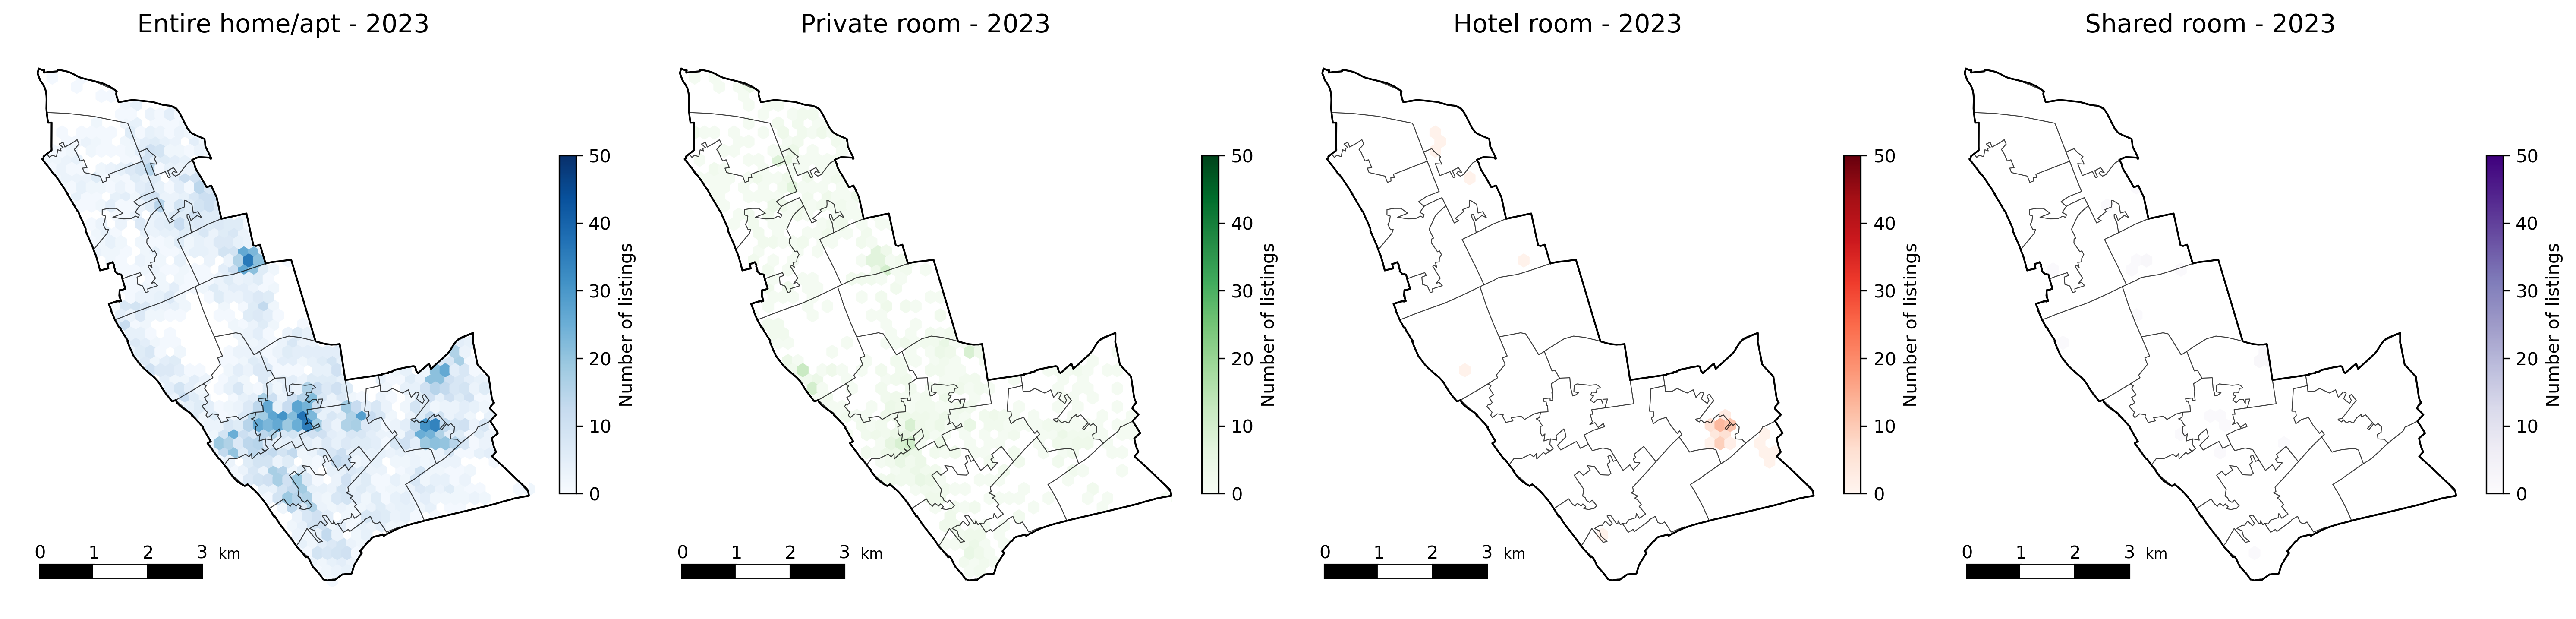

In [102]:
fig, axes = plt.subplots(1, 4, figsize=(20, 10), dpi=300)

for i, rtype in enumerate(room_types):
    ax = axes[i]
    df_type = df_2023[df_2023['room_type'] == rtype]

    if df_type.empty:
        KS_borough.plot(ax=ax, facecolor='grey', edgecolor='white', linewidth=0.5, zorder=1)
        ax.set_title(f"{rtype} - 2023\nNo Data", fontsize=14)
        ax.axis('off')
        continue

    gdf = gpd.GeoDataFrame(
        df_type,
        geometry=gpd.points_from_xy(df_type.longitude, df_type.latitude),
        crs='EPSG:4326'
    ).to_crs(epsg=27700)

    gdf = gpd.clip(gdf, KS_borough)
    if gdf.empty:
        KS_borough.plot(ax=ax, facecolor='grey', edgecolor='white', linewidth=0.5, zorder=1)
        ax.set_title(f"{rtype} - 2023\nNo Data after Clip", fontsize=14)
        ax.axis('off')
        continue

    x = gdf.geometry.x.values
    y = gdf.geometry.y.values

    current_cmap = cmaps_list[i]

    # 使用连续渐变，没有分级的bins
    hb = ax.hexbin(x, y, gridsize=50, cmap=current_cmap, norm=norm, extent=(minx, maxx, miny, maxy), mincnt=1, zorder=2)
    cb = plt.colorbar(hb, ax=ax, fraction=0.03, pad=0.01)
    cb.set_label("Number of listings")  # 连续渐变，无需指定ticks

    msoa_clipped = gpd.clip(msoa, KS_borough)
    msoa_clipped.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.5, zorder=3)

    KS_borough.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=0.6, zorder=4)

    outside_gs.plot(ax=ax, facecolor='white', edgecolor='none', zorder=5)

    KS_borough.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=6)

    add_scale_bar(ax, scale_bar_start=0.05, scale_bar_length=0.3, scale_bar_y=0.05,
                  scale_bar_thickness=150, scale_unit="km", labels_interval=1, zorder=7)

    ax.set_title(f"{rtype} - 2023", fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [106]:
cmaps_list2 = [
    truncate_colormap(cm.get_cmap('Blues'), 0.2, 1.0),
    truncate_colormap(cm.get_cmap('Greens'), 0.2, 1.0),
    truncate_colormap(cm.get_cmap('Reds'), 0.2, 1.0),
    truncate_colormap(cm.get_cmap('Purples'), 0.2, 1.0)
]


/tmp/ipykernel_30134/647079693.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  truncate_colormap(cm.get_cmap('Blues'), 0.2, 1.0),
/tmp/ipykernel_30134/647079693.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  truncate_colormap(cm.get_cmap('Greens'), 0.2, 1.0),
/tmp/ipykernel_30134/647079693.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  truncate_colormap(cm.get_cmap('Reds'), 0.2, 1.0),
/tmp/ipykernel_30134/647079693.py:5: MatplotlibDeprecationWarning: The get_cmap

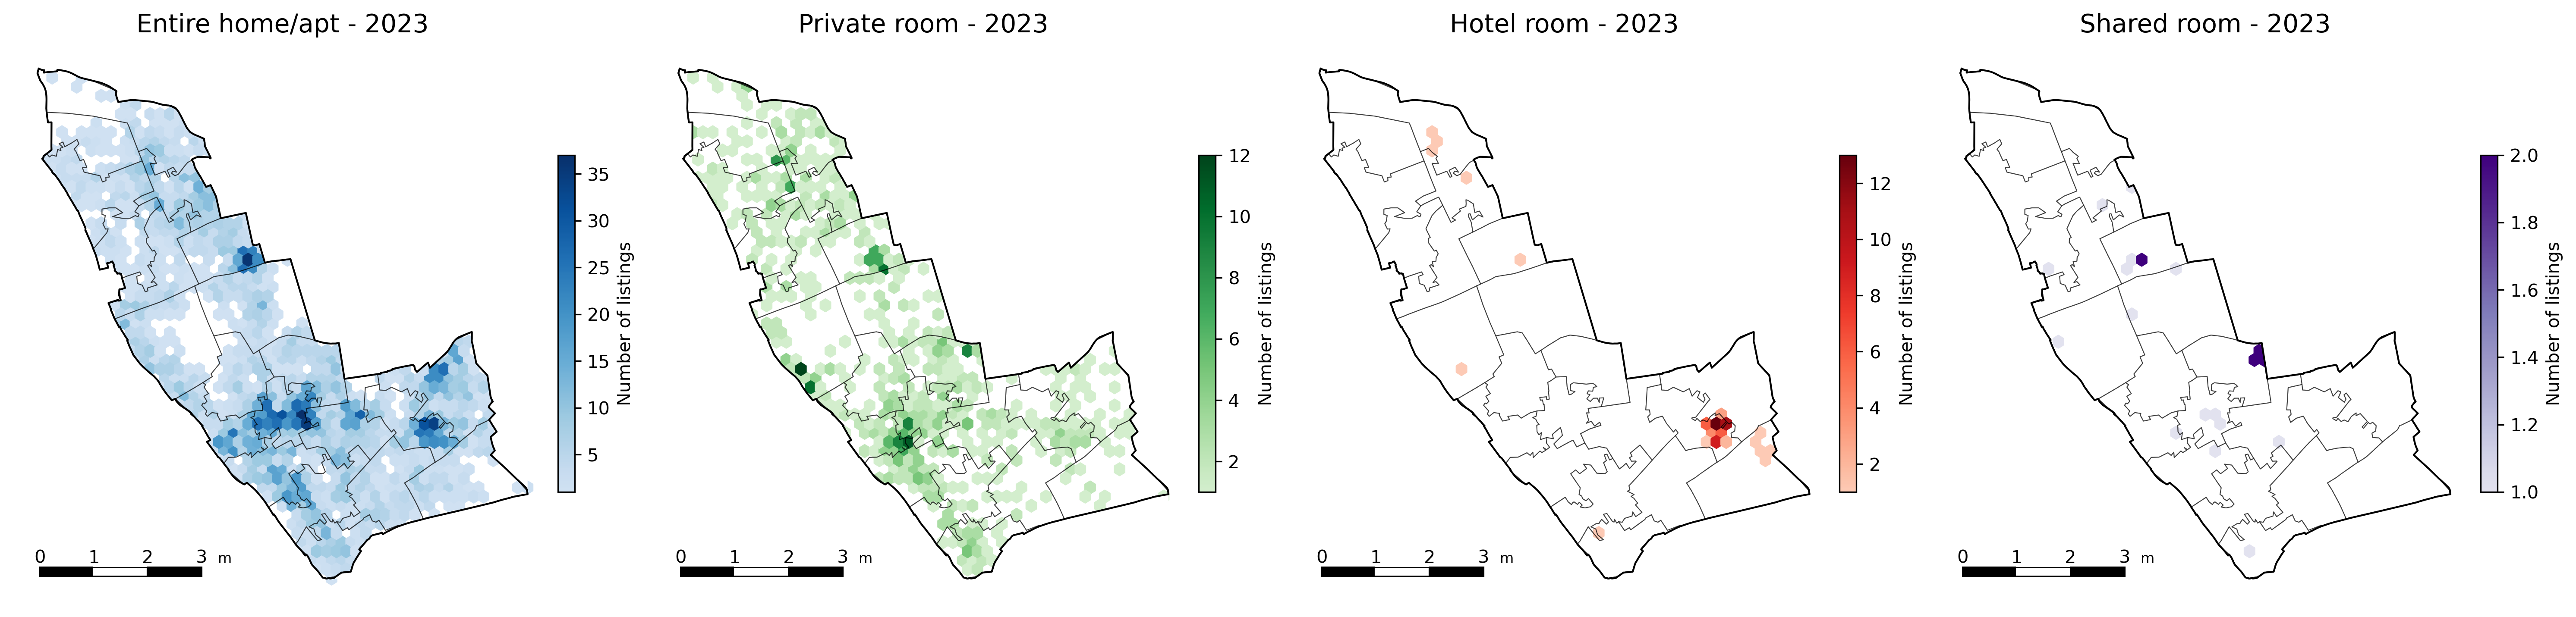

In [107]:
    

fig, axes = plt.subplots(1, 4, figsize=(20, 10), dpi=300)

for i, rtype in enumerate(room_types):
    ax = axes[i]
    df_type = df_2023[df_2023['room_type'] == rtype]

    if df_type.empty:
        KS_borough.plot(ax=ax, facecolor='grey', edgecolor='white', linewidth=0.5, zorder=1)
        ax.set_title(f"{rtype} - 2023\nNo Data", fontsize=14)
        ax.axis('off')
        continue

    gdf = gpd.GeoDataFrame(
        df_type,
        geometry=gpd.points_from_xy(df_type.longitude, df_type.latitude),
        crs='EPSG:4326'
    ).to_crs(epsg=27700)

    gdf = gpd.clip(gdf, KS_borough)
    if gdf.empty:
        KS_borough.plot(ax=ax, facecolor='grey', edgecolor='white', linewidth=0.5, zorder=1)
        ax.set_title(f"{rtype} - 2023\nNo Data after Clip", fontsize=14)
        ax.axis('off')
        continue

    x = gdf.geometry.x.values
    y = gdf.geometry.y.values

    current_cmap = cmaps_list2[i]

    # 不指定norm和bins，使用默认行为，根据数据自动确定颜色条范围
    hb = ax.hexbin(x, y, gridsize=50, cmap=current_cmap, extent=(minx, maxx, miny, maxy), mincnt=1, zorder=2)
    cb = plt.colorbar(hb, ax=ax, fraction=0.03, pad=0.01)
    cb.set_label("Number of listings")  # 不指定范围，采用默认数据范围

    msoa_clipped = gpd.clip(msoa, KS_borough)
    msoa_clipped.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.5, zorder=3)

    KS_borough.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=0.6, zorder=4)

    outside_gs.plot(ax=ax, facecolor='white', edgecolor='none', zorder=5)

    KS_borough.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=6)

    add_scale_bar(ax, scale_bar_start=0.05, scale_bar_length=0.3, scale_bar_y=0.05,
                  scale_bar_thickness=100, scale_unit="m", labels_interval=1)

    ax.set_title(f"{rtype} - 2023", fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()